# Дембицкий М.Е. ДЗ № 2

Оглавление

### Задание 1 
 Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

TF-IDF (от англ. term frequency и inverse document frequency — частота слова и обратная частота документа) — это показатель, который используется для оценки важности слова в документе.

Показатель TF-IDF оценивает значимость слова в документе, на основе данных о всей коллекции документов. Данная мера определяет вес слова за величину пропорциональную частоте его вхождения в документ и обратно пропорциональную частоте его вхождения во всех документах коллекции

Метрика TF-IDF используется в алгоритмах поисковых систем для проверки текстов. В частности, данный показатель включен в алгоритм проверки релевантности контента пользовательскому поисковому запросу.

### Задание 2
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

**Подгружаем библиотеки и данные**

In [1]:
import re
import pymorphy2
import pandas as pd
import numpy as np

import itertools
import matplotlib.pyplot as plt

#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

#Предобработка текста
from nltk.corpus import stopwords
from razdel import tokenize

# ml 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Метрики 
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix


%matplotlib inline

In [2]:
# Подгружаем данные
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
# Загрузим пользователей и списки последних прочитанных новостей
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


**Получаем векторные представления новостей**

In [4]:
# Создаем переменую со стоп-словами
stopword_ru = stopwords.words('russian')

# Инициализируем метод для морфологического анализа
morph = pymorphy2.MorphAnalyzer()

In [5]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [6]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [7]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-6-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 29.6 s


In [8]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 56s


А теперь в 3 строчки обучим нашу модель

In [9]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [10]:
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [11]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [12]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.24498527),
 (7, 0.14400323),
 (10, 0.043835897),
 (13, 0.43134123),
 (15, 0.06841857),
 (22, 0.050423745)]

In [13]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: лёд кит лосанджелес чикаго оливер астахов леонардо
topic_1: суд ракета год дело сотрудник источник nn
topic_2: граница северный препарат квартира питание мэй ресторан
topic_3: это который мочь новый система весь говорить
topic_4: рубль убийство статья млн дело женщина млрд
topic_5: спрос писать отдых модель сестра устойчивость химия
topic_6: украина украинский россия лаборатория президент киев российский
topic_7: год который это сша россия американский земля
topic_8: рак запустить вирус перевод лауреат египетский берег
topic_9: год это который россия обнаружить свой около
topic_10: рейтинг японский япония место лодка кг вес
topic_11: рейс высота ск украина израиль донбасс аналог
topic_12: фонд доход остров предприниматель увеличение исследование следствие
topic_13: журнал тело первый экипаж это вицепремьер который
topic_14: одежда нож австралийский поражать новосибирский новосибирск натуральный
topic_15: смерть восток звезда знаменитый год умереть группа
topic_16: год который 

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [14]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [15]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.517452,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.165940,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,4896,0.0,0.579754,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,4897,0.0,0.000000,0.0,0.244952,0.0,0.0,0.0,0.144073,0.0,...,0.068479,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.050388,0.0,0.0
3,4898,0.0,0.000000,0.0,0.259382,0.0,0.0,0.0,0.146457,0.0,...,0.000000,0.053773,0.019867,0.0,0.0,0.138663,0.063806,0.000000,0.0,0.0
4,4899,0.0,0.865456,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


**Следующий шаг - векторные представления пользователей**

In [16]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [17]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [18]:
doc_dict[293622]

array([0.        , 0.09498195, 0.05599175, 0.        , 0.        ,
       0.        , 0.        , 0.19435683, 0.        , 0.07784178,
       0.        , 0.09382221, 0.        , 0.        , 0.        ,
       0.21464092, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10663167, 0.        , 0.12255037, 0.02947178])

In [19]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [20]:
get_user_embedding(user_articles_list)

array([0.        , 0.0648478 , 0.        , 0.11522748, 0.        ,
       0.        , 0.        , 0.14254997, 0.        , 0.0286949 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10944889, 0.        , 0.        , 0.        ,
       0.01848881, 0.00696588, 0.12189537, 0.01238738, 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [21]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.060991,0.0,0.000000,0.000000,0.0,0.000000,0.024734,0.0,...,0.0,0.049843,0.0,0.000000,0.000000,0.049198,0.000000,0.075874,0.000000,0.000000
1,u108690,0.0,0.021200,0.0,0.119736,0.011807,0.0,0.134497,0.074971,0.0,...,0.0,0.084756,0.0,0.000000,0.000000,0.032813,0.006029,0.201043,0.000000,0.013544
2,u108339,0.0,0.117465,0.0,0.036054,0.036751,0.0,0.000000,0.059759,0.0,...,0.0,0.137292,0.0,0.024917,0.013885,0.115636,0.018864,0.099307,0.011685,0.000000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [22]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [23]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.060991,0.0,0.000000,0.000000,0.0,0.000000,0.024734,0.0,...,0.049843,0.0,0.000000,0.000000,0.049198,0.000000,0.075874,0.000000,0.000000,0
1,u108690,0.0,0.021200,0.0,0.119736,0.011807,0.0,0.134497,0.074971,0.0,...,0.084756,0.0,0.000000,0.000000,0.032813,0.006029,0.201043,0.000000,0.013544,1
2,u108339,0.0,0.117465,0.0,0.036054,0.036751,0.0,0.000000,0.059759,0.0,...,0.137292,0.0,0.024917,0.013885,0.115636,0.018864,0.099307,0.011685,0.000000,1


In [24]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [25]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [26]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.09104131, 0.01463973, 0.53290048, 0.55012846, 0.00820934,
       0.02247644, 0.08180378, 0.02638857, 0.01830137, 0.08731697])

**Рассчитаем Precision, Recall, F_score**

In [27]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.287089, F-Score=0.740, Precision=0.668, Recall=0.829


In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1654  101]
 [  43  202]]


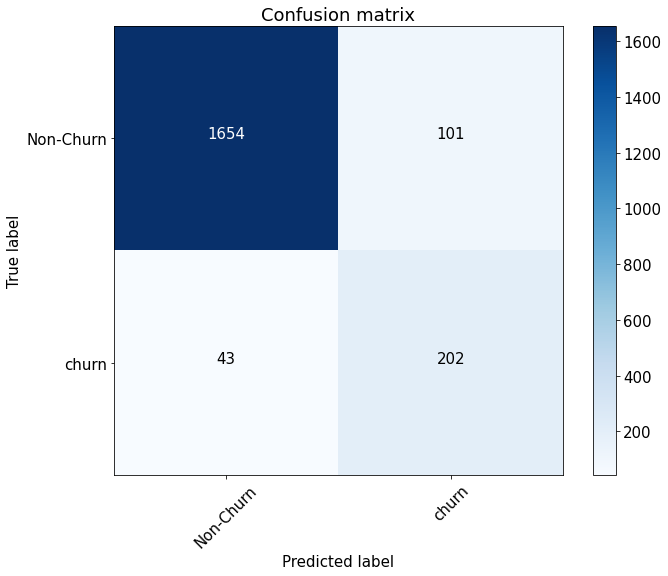

In [29]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [30]:
print('Roc Auc=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (roc_auc_score(y_test, preds), 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
median_data= [roc_auc_score(y_test, preds), fscore[ix], precision[ix], recall[ix]]

Roc Auc=0.963898, F-Score=0.740, Precision=0.668, Recall=0.829


### Задание 3
Повторить п.2, но используя уже не медиану, а max

In [31]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [32]:
get_user_embedding(user_articles_list)

array([0.        , 0.35174158, 0.        , 0.29204699, 0.32489321,
       0.        , 0.19872831, 0.28394511, 0.        , 0.19135745,
       0.        , 0.        , 0.03956333, 0.0142649 , 0.        ,
       0.04758028, 0.4158977 , 0.03786026, 0.        , 0.        ,
       0.11654945, 0.09096551, 0.37544641, 0.2070908 , 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [33]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.212962,0.055992,0.071622,0.036884,0.076773,0.381034,0.194357,0.034689,...,0.214641,0.364093,0.000000,0.077848,0.000000,0.402906,0.106632,0.235236,0.255740,0.029472
1,u108690,0.010095,0.381847,0.000000,0.270027,0.155912,0.000000,0.240127,0.166188,0.000000,...,0.026531,0.160321,0.000000,0.053026,0.025091,0.143636,0.056504,0.254002,0.070454,0.053280
2,u108339,0.000000,0.252945,0.000000,0.093698,0.191093,0.011513,0.116722,0.277906,0.000000,...,0.060658,0.240913,0.032194,0.168342,0.021943,0.190178,0.027362,0.163703,0.088443,0.043534


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [34]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.212962,0.055992,0.071622,0.036884,0.076773,0.381034,0.194357,0.034689,...,0.364093,0.000000,0.077848,0.000000,0.402906,0.106632,0.235236,0.255740,0.029472,0
1,u108690,0.010095,0.381847,0.000000,0.270027,0.155912,0.000000,0.240127,0.166188,0.000000,...,0.160321,0.000000,0.053026,0.025091,0.143636,0.056504,0.254002,0.070454,0.053280,1
2,u108339,0.000000,0.252945,0.000000,0.093698,0.191093,0.011513,0.116722,0.277906,0.000000,...,0.240913,0.032194,0.168342,0.021943,0.190178,0.027362,0.163703,0.088443,0.043534,1


In [35]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [36]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [37]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([1.61668593e-02, 1.34859811e-04, 7.47797335e-01, 4.19723458e-01,
       3.32153181e-02, 3.09655099e-02, 2.54693179e-02, 5.16014289e-03,
       4.24151116e-03, 2.85592694e-02])

**Рассчитаем Precision, Recall, F_score**

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.358138, F-Score=0.786, Precision=0.770, Recall=0.804


Confusion matrix, without normalization
[[1696   59]
 [  49  196]]


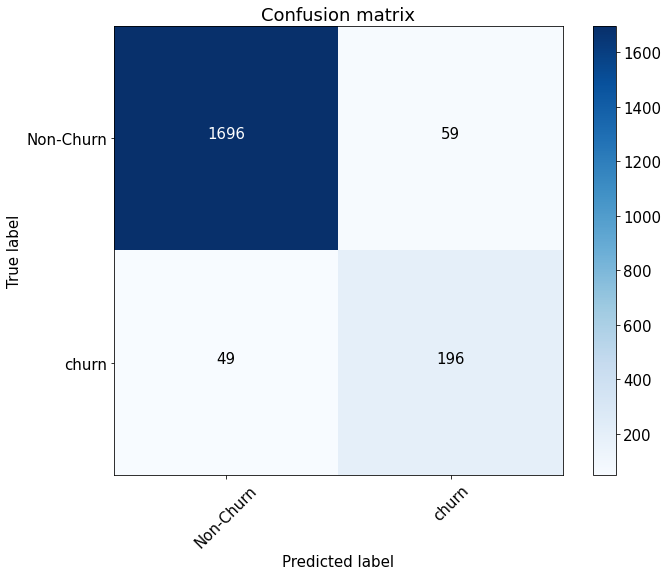

In [39]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [40]:
print('Roc Auc=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (roc_auc_score(y_test, preds), 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
max_data= [roc_auc_score(y_test, preds), fscore[ix], precision[ix], recall[ix]]

Roc Auc=0.969631, F-Score=0.786, Precision=0.770, Recall=0.804


### Задание 5
Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, по метрикам roc_auc, precision, recall, f_score

**mean**

In [41]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [42]:
get_user_embedding(user_articles_list)

array([0.        , 0.11537596, 0.        , 0.12567114, 0.05414887,
       0.        , 0.0637685 , 0.13743851, 0.        , 0.06866894,
       0.        , 0.        , 0.01105838, 0.00237748, 0.        ,
       0.00793005, 0.1429536 , 0.00631004, 0.        , 0.        ,
       0.04445089, 0.02142098, 0.14132264, 0.04378704, 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [43]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.082526,0.009332,0.011937,0.011269,0.012795,0.070814,0.060717,0.009148,...,0.046149,0.100235,0.000000,0.025225,0.000000,0.113083,0.031605,0.099927,0.063048,0.004912
1,u108690,0.001683,0.106266,0.000000,0.113499,0.045270,0.000000,0.114844,0.072563,0.000000,...,0.007052,0.085298,0.000000,0.012880,0.005968,0.047173,0.014506,0.174261,0.021730,0.018128
2,u108339,0.000000,0.124407,0.000000,0.038313,0.056989,0.001919,0.028130,0.105684,0.000000,...,0.010110,0.142070,0.005366,0.048619,0.010799,0.104674,0.014661,0.099033,0.023889,0.007256


In [44]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.082526,0.009332,0.011937,0.011269,0.012795,0.070814,0.060717,0.009148,...,0.100235,0.000000,0.025225,0.000000,0.113083,0.031605,0.099927,0.063048,0.004912,0
1,u108690,0.001683,0.106266,0.000000,0.113499,0.045270,0.000000,0.114844,0.072563,0.000000,...,0.085298,0.000000,0.012880,0.005968,0.047173,0.014506,0.174261,0.021730,0.018128,1
2,u108339,0.000000,0.124407,0.000000,0.038313,0.056989,0.001919,0.028130,0.105684,0.000000,...,0.142070,0.005366,0.048619,0.010799,0.104674,0.014661,0.099033,0.023889,0.007256,1


In [45]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [46]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [47]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07151196, 0.02434599, 0.41641917, 0.23876268, 0.01897898,
       0.10446777, 0.11354115, 0.03138501, 0.01813406, 0.09858443])

**Рассчитаем Precision, Recall, F_score**

In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.276491, F-Score=0.630, Precision=0.605, Recall=0.657


Confusion matrix, without normalization
[[1650  105]
 [  85  160]]


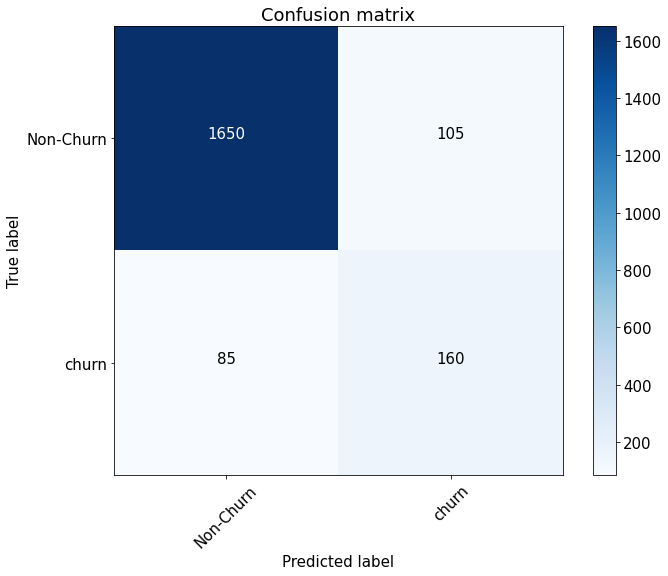

In [49]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [50]:
print('Roc Auc=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (roc_auc_score(y_test, preds), 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
mean_data= [roc_auc_score(y_test, preds), fscore[ix], precision[ix], recall[ix]]

Roc Auc=0.930580, F-Score=0.630, Precision=0.605, Recall=0.657


In [51]:
columns = ('Roc Auc', 'F-score', 'Precision', 'Recall')
rows = ('median', 'max', 'mean')
data = [median_data, max_data, mean_data]

concl = pd.DataFrame(data, rows, columns)
concl

,Roc Auc,F-score,Precision,Recall
median,0.963898,0.739526,0.667763,0.828571
max,0.969631,0.786427,0.769531,0.804082
mean,0.930580,0.630137,0.605263,0.657143


### Задание 6
Сделать выводы  о том, какой способ оказался эффективнее остальных

* Использование np.max при формировании эмбеддинга пользователя показал наилучшие результаты по 3 из 4 метрик
* Скор по метрике Recall лучше всего при использовании np.median
* Использование np.mean дает худшие метрики для выполнения задачи, использование не рекомендуется